# Zadania

Zaimplementuj w **PyTorch** następujące modele sieci rekurencyjnych:
- **Simple RNN**
- **LSTM**
- **BiLSTM**
- **GRU**
- **BiGRU**

Dla każdego typu sieci zaproponuj **po dwie różne architektury** (np. różniące się liczbą warstw, rozmiarem warstw ukrytych, dropoutem itp.). W procesie uczenia wykorzystaj mechanizm **Early Stopping** oparty na **Validation Loss**.

Skorzystaj z poniższego **datasetu** do trenowania i ewaluacji modeli. Wykorzystaj dataset dołączony do zadania oraz zapoznaj sie z bilbioteka TorchText i wybierz dataset (https://pytorch.org/text/stable/index.html) np. AmazonReview, YelpReviewFull czy YahooAnswers.

Finalnie zadanie ma być wykonane na dwóch datasetach!

## Analiza i prezentacja wyników

W ramach analizy i prezentacji wyników wykonaj następujące kroki:

1. **Wizualizacje metryk na przestrzeni epok**:
   - Wykresy **Train Accuracy** i **Validation Accuracy**,
   - Wykresy **Train F1-Score** i **Validation F1-Score**,
   - Po zakończeniu uczenia przedstaw **Test Accuracy** i **Test F1-Score** dla najlepszego modelu.

2. **Wizualizacje danych**:
   - Przed i po procesie **clean-up** danych tekstowych przedstaw:
     - Przykładowe **n-gramy** (np. bigramy, trigramy),
     - Wizualizacje **WordCloud** dla danych surowych i oczyszczonych.

3. **Eksperymenty**:
   - Uruchom każdy model **minimum 3 razy** (z różnymi inicjalizacjami wag),
   - Dla każdej architektury przedstaw wyniki (**Accuracy**, **F1-Score**) po ostatniej najlepszej epoce przed zadziałaniem **Early Stoppingu**.

4. **Porównanie z modelem bazowym**:
   - Porównaj wyniki uzyskane z powyższych modeli z wynikami modelu klasyfikacji tekstu opartego na **Word Embedding** (np. z Lab01, wykorzystując statyczne embeddingi typu GloVe lub word2vec).

5. **Wnioski**:
   - Przeanalizuj i podsumuj, która architektura sieci (**Simple RNN**, **LSTM**, **BiLSTM**, **GRU**, **BiGRU**) sprawuje się najlepiej na danym zbiorze danych, uwzględniając metryki **Accuracy** i **F1-Score** oraz stabilność wyników.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import bigrams, trigrams
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import urllib.request
import zipfile

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')


# Ustawienie GPU, jeśli jest dostępne
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Używane urządzenie: {device}")

Używane urządzenie: cuda


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Jan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
#Wczytanie datasetu
df = pd.read_csv('amazon_reviews.csv')
print(f"Dataset shape: {df.shape}")
print(f"Dataset Types: {df.dtypes}")
print(f"Cleaned reviews: {df['cleaned_review']}")
print(df.head())

Dataset shape: (17340, 4)
Dataset Types: sentiments                object
cleaned_review            object
cleaned_review_length      int64
review_score             float64
dtype: object
Cleaned reviews: 0        i wish would have gotten one earlier love it a...
1        i ve learned this lesson again open the packag...
2                it is so slow and lags find better option
3        roller ball stopped working within months of m...
4        i like the color and size but it few days out ...
                               ...                        
17335    i love this speaker and love can take it anywh...
17336    i use it in my house easy to connect and loud ...
17337    the bass is good and the battery is amazing mu...
17338                                              love it
17339                                         mono speaker
Name: cleaned_review, Length: 17340, dtype: object
  sentiments                                     cleaned_review  \
0   positive  i wish would ha

In [4]:
# Wczytanie datasetu 2
def load_yelp_review_full():
    """Loads the YelpReviewFull dataset."""


    train_df = pd.read_csv("yelp_review_full_csv/train.csv", header=None, names=['label', 'text'])
    test_df = pd.read_csv("yelp_review_full_csv/test.csv", header=None, names=['label', 'text'])

    # Combine train and test for simplicity
    df = pd.concat([train_df, test_df], ignore_index=True)


    return df

dfYelp = load_yelp_review_full()

In [5]:
#Funkcja wizualizacyjna
# Function for n-gram and word cloud visualization
def visualize_text_features(text_series, title_prefix=""):
    
    all_text = text_series
    
    # Get bigrams and trigrams
    bi_grams = list(bigrams(all_text.split()))
    tri_grams = list(trigrams(all_text.split()))
    
    # Calculate frequency distributions
    bi_fdist = FreqDist(bi_grams)
    tri_fdist = FreqDist(tri_grams)
    
    # Get top 15 bigrams and trigrams
    top_bi = bi_fdist.most_common(15)
    top_tri = tri_fdist.most_common(15)
    
    # Create word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
    
    # Visualize
    fig, axes = plt.subplots(3, 1, figsize=(12, 12))
    
    # Plot word cloud
    axes[0].imshow(wordcloud, interpolation='bilinear')
    axes[0].set_title(f"{title_prefix} Word Cloud")
    axes[0].axis('off')
    
    # Plot bigrams
    sns.barplot(x=[' '.join(bg[0]) for bg in top_bi], y=[bg[1] for bg in top_bi], ax=axes[1])
    axes[1].set_title(f"{title_prefix} Top 15 Bigrams")
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
    
    # Plot trigrams
    sns.barplot(x=[' '.join(tg[0]) for tg in top_tri], y=[tg[1] for tg in top_tri], ax=axes[2])
    axes[2].set_title(f"{title_prefix} Top 15 Trigrams")
    axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

In [6]:
# Preprocesowanie i połączenie tekstu
def preprocess_and_concatenate(df, column_name):

    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in the DataFrame.")
        return None

    if df[column_name].empty:
        print(f"Column '{column_name}' is empty.")
        return None

    stop_words = set(stopwords.words('english'))
    processed_texts = []

    for text in df[column_name].astype(str):  # Ensure string type
        words = word_tokenize(text)
        filtered_words = [word.lower() for word in words if word.lower() not in stop_words and word.isalnum()] #lower case and remove non alphanumeric
        processed_texts.append(" ".join(filtered_words))

    concatenated_string = "".join(processed_texts)
    return concatenated_string, processed_texts

C:\Users\Jan\AppData\Local\Temp\ipykernel_21324\3266804556.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
C:\Users\Jan\AppData\Local\Temp\ipykernel_21324\3266804556.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')


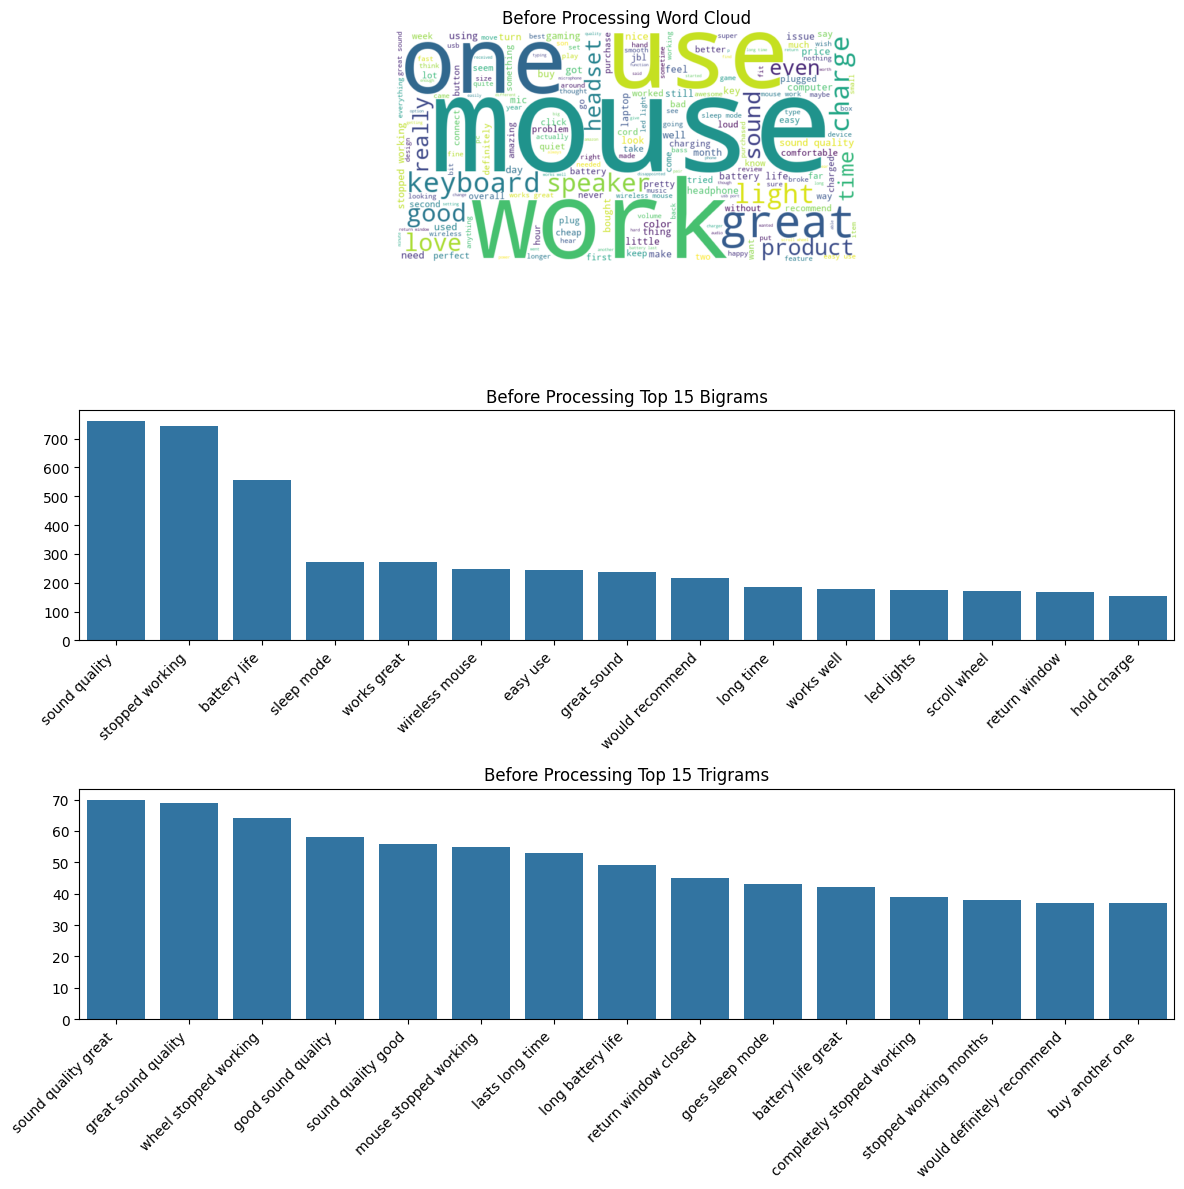

In [5]:
#Wizualizacja przed czyszczeniem
processed_string, processed_text_array = preprocess_and_concatenate(df, 'cleaned_review')
visualize_text_features(processed_string, "Before Processing")

In [6]:
# Enkodowanie sentymentów
label_encoder = LabelEncoder()
df['encoded_sentiment'] = label_encoder.fit_transform(df['sentiments'])


In [7]:
# Budowa słownika
def build_vocab(texts, max_vocab_size=10000):
    word_counts = Counter()
    for text in texts:
        tokens = word_tokenize(text)
        for word in tokens:
            word_counts[word.lower()] += 1

    most_common_words = [word for word, _ in word_counts.most_common(max_vocab_size - 1)]
    most_common_words.append('<UNK>')

    word_to_idx = {word: i + 1 for i, word in enumerate(most_common_words)}
    return word_to_idx

word_to_idx = build_vocab(processed_text_array)
vocab_size = len(word_to_idx) + 1  # +1 for padding
print(f"Vocabulary size: {vocab_size}")


Vocabulary size: 9449


In [8]:
# Convert text to sequences of indices
def text_to_sequence(text, word_to_idx, max_length=None):
    sequence = [word_to_idx.get(word, 0) for word in text.split()]
    if max_length:
        if len(sequence) > max_length:
            sequence = sequence[:max_length]
        else:
            sequence = sequence + [0] * (max_length - len(sequence))
    return sequence

# Determine maximum sequence length (can be set to a specific value if needed)
max_length = int(df['cleaned_review_length'].quantile(0.95))  # Using 95th percentile to avoid outliers
print(f"Maximum sequence length: {max_length}")

Maximum sequence length: 92


In [9]:
# Create PyTorch dataset
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, word_to_idx, max_length):
        self.texts = texts
        self.labels = labels
        self.word_to_idx = word_to_idx
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Convert text to sequence
        sequence = text_to_sequence(text, self.word_to_idx, self.max_length)
        
        return {
            'text': torch.tensor(sequence, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [10]:
# Split data into train, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    processed_text_array, df['encoded_sentiment'].values, 
    test_size=0.3, random_state=42, stratify=df['encoded_sentiment'].values
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, 
    test_size=0.5, random_state=42, stratify=temp_labels
)

# Create datasets
train_dataset = ReviewDataset(train_texts, train_labels, word_to_idx, max_length)
val_dataset = ReviewDataset(val_texts, val_labels, word_to_idx, max_length)
test_dataset = ReviewDataset(test_texts, test_labels, word_to_idx, max_length)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [16]:
# Definicja modeli
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout=0.5):
        super(SimpleRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.rnn(embedded)
        return self.fc(hidden.squeeze(0))

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout=0.5):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        return self.fc(hidden.squeeze(0))

class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout=0.5):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        return self.fc(hidden)

class GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout=0.5):
        super(GRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.gru(embedded)
        return self.fc(hidden.squeeze(0))

class BiGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout=0.5):
        super(BiGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.gru(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        return self.fc(hidden)

In [12]:
#Funkcja treningowa
def train_model(model, train_loader, val_loader, optimizer, criterion, device, n_epochs=10, patience=3):
    model.to(device)
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    
    train_losses = []
    val_losses = []
    
    for epoch in range(n_epochs):
        # Training
        model.train()
        train_loss = 0
        
        for batch in train_loader:
            texts = batch['text'].to(device)
            labels = batch['label'].to(device)
            
            optimizer.zero_grad()
            predictions = model(texts)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss = train_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for batch in val_loader:
                texts = batch['text'].to(device)
                labels = batch['label'].to(device)
                
                predictions = model(texts)
                loss = criterion(predictions, labels)
                
                val_loss += loss.item()
        
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        
        print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'{model_name}_best_model.pt')
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f'Early stopping after {epoch+1} epochs.')
                break
    
    # Load best model for evaluation
    model.load_state_dict(torch.load(f'{model_name}_best_model.pt'))
    
    return model, train_losses, val_losses


In [13]:
#Funkcja evaluacyjna
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            texts = batch['text'].to(device)
            labels = batch['label'].to(device)
            
            predictions = model(texts)
            loss = criterion(predictions, labels)
            
            test_loss += loss.item()
            
            predicted_labels = torch.argmax(predictions, dim=1)
            all_predictions.extend(predicted_labels.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = test_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_predictions)
    report = classification_report(all_labels, all_predictions, target_names=label_encoder.classes_)
    
    return test_loss, accuracy, report


Training SimpleRNN...
Epoch: 1, Train Loss: 0.9297, Val Loss: 0.9157
Epoch: 2, Train Loss: 0.9186, Val Loss: 0.9228
Epoch: 3, Train Loss: 0.9163, Val Loss: 0.9126
Epoch: 4, Train Loss: 0.9164, Val Loss: 0.9169
Epoch: 5, Train Loss: 0.9136, Val Loss: 0.9198
Epoch: 6, Train Loss: 0.9115, Val Loss: 0.9125
Epoch: 7, Train Loss: 0.9118, Val Loss: 0.9309
Epoch: 8, Train Loss: 0.9105, Val Loss: 0.9189
Epoch: 9, Train Loss: 0.9098, Val Loss: 0.9193
Epoch: 10, Train Loss: 0.9101, Val Loss: 0.9148
Epoch: 11, Train Loss: 0.9115, Val Loss: 0.9185
Early stopping after 11 epochs.
SimpleRNN Test Loss: 0.9111, Accuracy: 0.5479
Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       230
     neutral       0.00      0.00      0.00       945
    positive       0.55      1.00      0.71      1426

    accuracy                           0.55      2601
   macro avg       0.18      0.33      0.24      2601
weighted avg       0.30      0.

c:\Users\Jan\.version-fox\cache\python\current\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jan\.version-fox\cache\python\current\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jan\.version-fox\cache\python\current\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

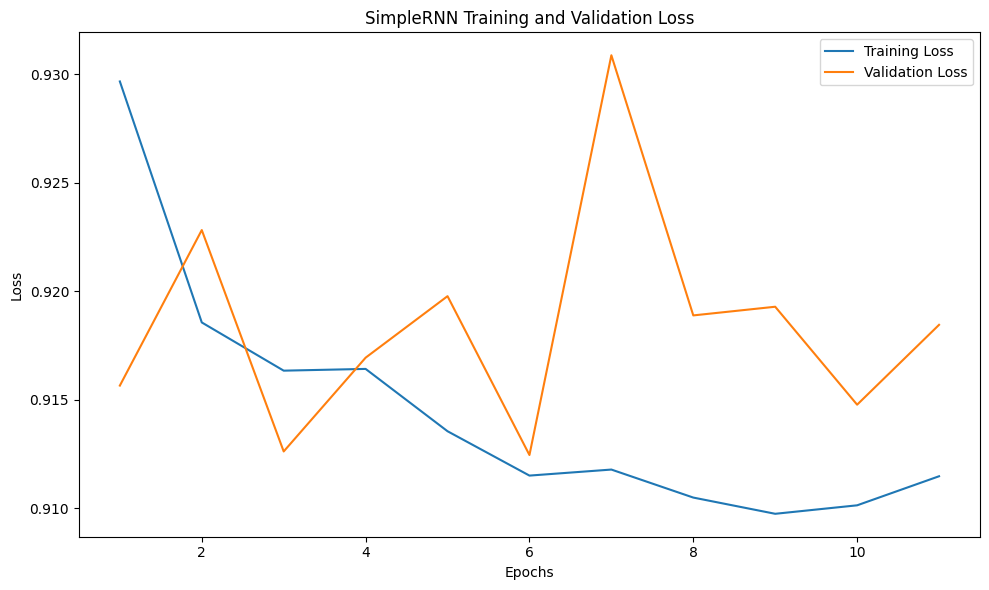


Training LSTM...
Epoch: 1, Train Loss: 0.9208, Val Loss: 0.9158
Epoch: 2, Train Loss: 0.9150, Val Loss: 0.9130
Epoch: 3, Train Loss: 0.9122, Val Loss: 0.9114
Epoch: 4, Train Loss: 0.9118, Val Loss: 0.9119
Epoch: 5, Train Loss: 0.8296, Val Loss: 0.6948
Epoch: 6, Train Loss: 0.7298, Val Loss: 0.6427
Epoch: 7, Train Loss: 0.6639, Val Loss: 0.6104
Epoch: 8, Train Loss: 0.6134, Val Loss: 0.6026
Epoch: 9, Train Loss: 0.5779, Val Loss: 0.5355
Epoch: 10, Train Loss: 0.5466, Val Loss: 0.5759
Epoch: 11, Train Loss: 0.5131, Val Loss: 0.5383
Epoch: 12, Train Loss: 0.4860, Val Loss: 0.4933
Epoch: 13, Train Loss: 0.4657, Val Loss: 0.4604
Epoch: 14, Train Loss: 0.4484, Val Loss: 0.5322
Epoch: 15, Train Loss: 0.4245, Val Loss: 0.5007
Epoch: 16, Train Loss: 0.4125, Val Loss: 0.5049
Epoch: 17, Train Loss: 0.3927, Val Loss: 0.5032
Epoch: 18, Train Loss: 0.3705, Val Loss: 0.5474
Early stopping after 18 epochs.
LSTM Test Loss: 0.4933, Accuracy: 0.8139
Classification Report:
              precision    reca

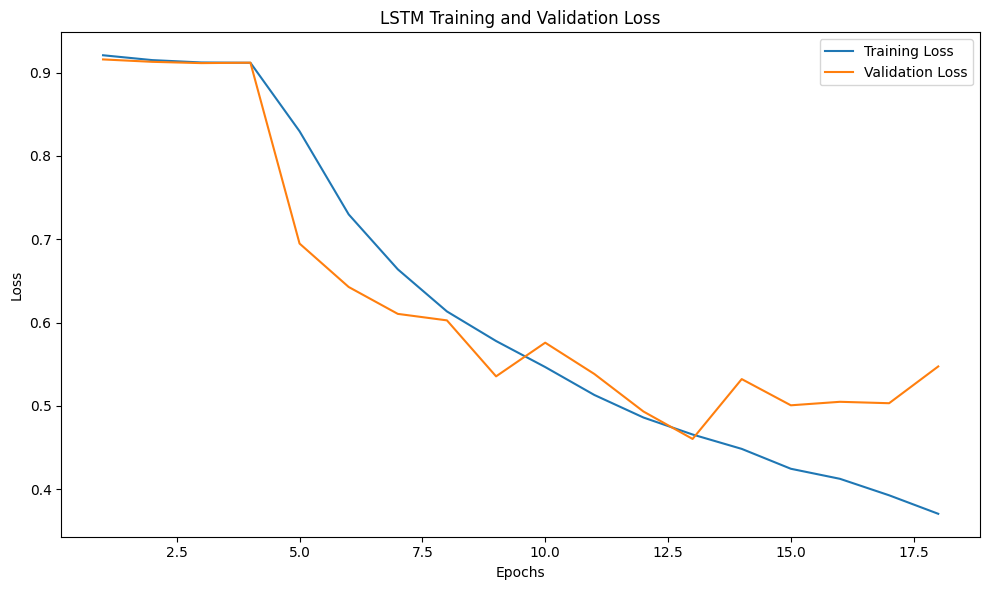


Training BiLSTM...
Epoch: 1, Train Loss: 0.7403, Val Loss: 0.6454
Epoch: 2, Train Loss: 0.6065, Val Loss: 0.5734
Epoch: 3, Train Loss: 0.5476, Val Loss: 0.6021
Epoch: 4, Train Loss: 0.5070, Val Loss: 0.5232
Epoch: 5, Train Loss: 0.4698, Val Loss: 0.4885
Epoch: 6, Train Loss: 0.4422, Val Loss: 0.5078
Epoch: 7, Train Loss: 0.4156, Val Loss: 0.6118
Epoch: 8, Train Loss: 0.3855, Val Loss: 0.5099
Epoch: 9, Train Loss: 0.3655, Val Loss: 0.4769
Epoch: 10, Train Loss: 0.3474, Val Loss: 0.5129
Epoch: 11, Train Loss: 0.3302, Val Loss: 0.5149
Epoch: 12, Train Loss: 0.3124, Val Loss: 0.5950
Epoch: 13, Train Loss: 0.2988, Val Loss: 0.4746
Epoch: 14, Train Loss: 0.2808, Val Loss: 0.5681
Epoch: 15, Train Loss: 0.2677, Val Loss: 0.5131
Epoch: 16, Train Loss: 0.2644, Val Loss: 0.5554
Epoch: 17, Train Loss: 0.2439, Val Loss: 0.4873
Epoch: 18, Train Loss: 0.2360, Val Loss: 0.5544
Early stopping after 18 epochs.
BiLSTM Test Loss: 0.5233, Accuracy: 0.8308
Classification Report:
              precision    

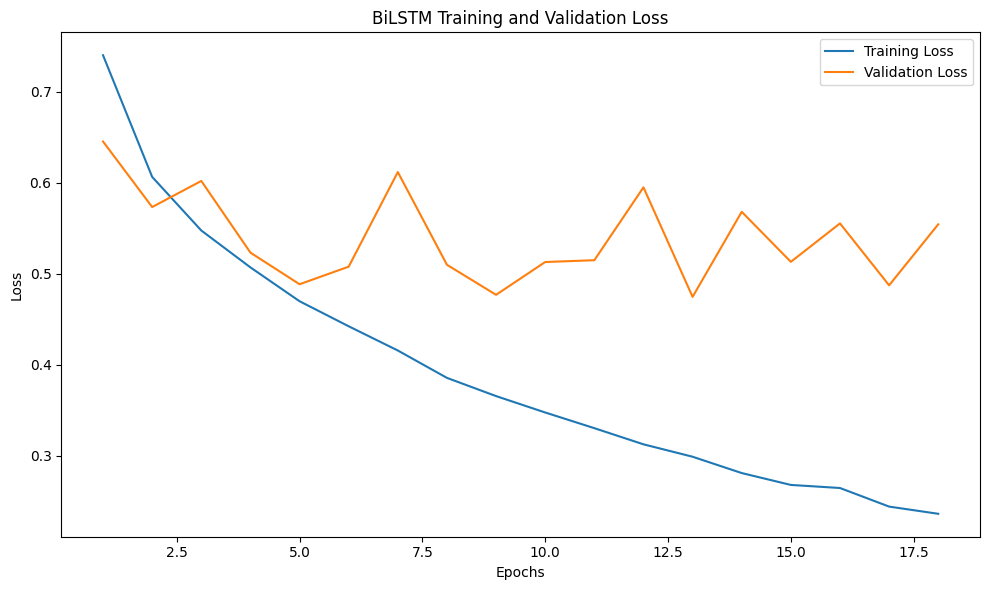


Training GRU...
Epoch: 1, Train Loss: 0.9220, Val Loss: 0.9110
Epoch: 2, Train Loss: 0.7885, Val Loss: 0.6158
Epoch: 3, Train Loss: 0.6404, Val Loss: 0.5471
Epoch: 4, Train Loss: 0.5725, Val Loss: 0.4962
Epoch: 5, Train Loss: 0.5158, Val Loss: 0.4602
Epoch: 6, Train Loss: 0.4801, Val Loss: 0.4659
Epoch: 7, Train Loss: 0.4481, Val Loss: 0.4560
Epoch: 8, Train Loss: 0.4298, Val Loss: 0.4177
Epoch: 9, Train Loss: 0.4139, Val Loss: 0.4425
Epoch: 10, Train Loss: 0.3878, Val Loss: 0.4089
Epoch: 11, Train Loss: 0.3723, Val Loss: 0.4446
Epoch: 12, Train Loss: 0.3480, Val Loss: 0.3944
Epoch: 13, Train Loss: 0.3400, Val Loss: 0.4224
Epoch: 14, Train Loss: 0.3251, Val Loss: 0.4437
Epoch: 15, Train Loss: 0.3092, Val Loss: 0.4877
Epoch: 16, Train Loss: 0.3021, Val Loss: 0.4389
Epoch: 17, Train Loss: 0.2834, Val Loss: 0.4655
Early stopping after 17 epochs.
GRU Test Loss: 0.4478, Accuracy: 0.8304
Classification Report:
              precision    recall  f1-score   support

    negative       0.57   

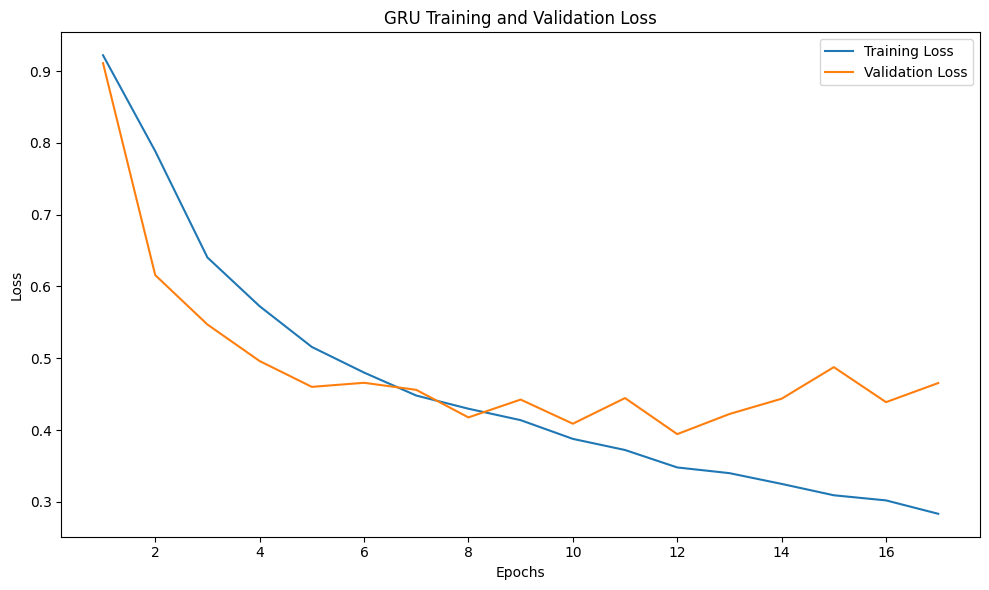


Training BiGRU...
Epoch: 1, Train Loss: 0.7385, Val Loss: 0.5821
Epoch: 2, Train Loss: 0.6066, Val Loss: 0.5653
Epoch: 3, Train Loss: 0.5377, Val Loss: 0.5184
Epoch: 4, Train Loss: 0.4914, Val Loss: 0.4814
Epoch: 5, Train Loss: 0.4561, Val Loss: 0.4615
Epoch: 6, Train Loss: 0.4317, Val Loss: 0.4642
Epoch: 7, Train Loss: 0.4035, Val Loss: 0.4845
Epoch: 8, Train Loss: 0.3844, Val Loss: 0.5335
Epoch: 9, Train Loss: 0.3594, Val Loss: 0.4861
Epoch: 10, Train Loss: 0.3328, Val Loss: 0.4980
Early stopping after 10 epochs.
BiGRU Test Loss: 0.5004, Accuracy: 0.8032
Classification Report:
              precision    recall  f1-score   support

    negative       0.56      0.45      0.50       230
     neutral       0.76      0.74      0.75       945
    positive       0.86      0.90      0.88      1426

    accuracy                           0.80      2601
   macro avg       0.73      0.70      0.71      2601
weighted avg       0.80      0.80      0.80      2601



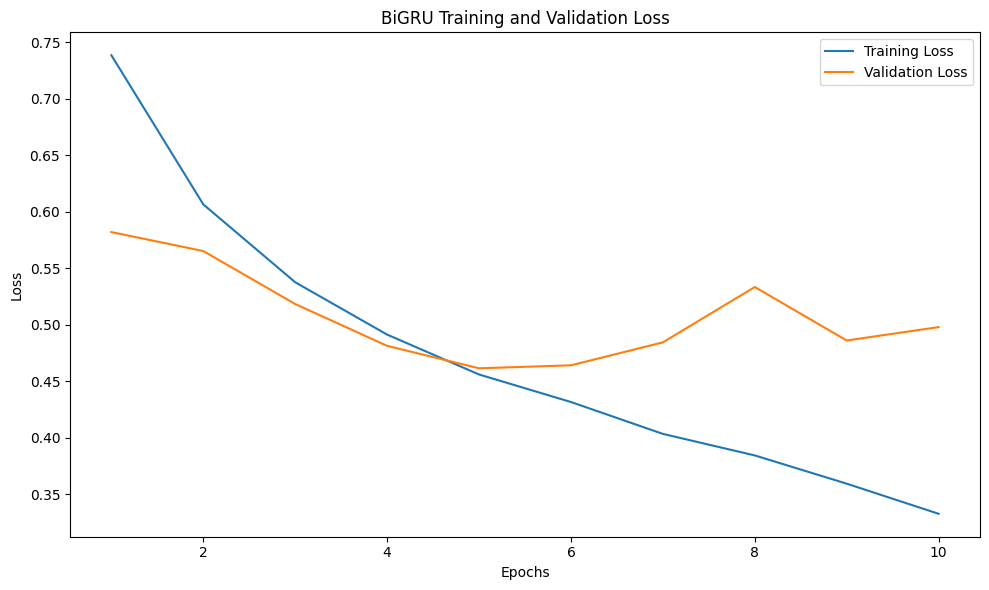

In [14]:
#Trenowanie modeli
# Model hyperparameters
embedding_dim = 100
hidden_dim = 128
output_dim = len(label_encoder.classes_)
learning_rate = 0.001
n_epochs = 60
patience = 5

# List of models to train
models = {
    'SimpleRNN': SimpleRNN(vocab_size, embedding_dim, hidden_dim, output_dim),
    'LSTM': LSTM(vocab_size, embedding_dim, hidden_dim, output_dim),
    'BiLSTM': BiLSTM(vocab_size, embedding_dim, hidden_dim, output_dim),
    'GRU': GRU(vocab_size, embedding_dim, hidden_dim, output_dim),
    'BiGRU': BiGRU(vocab_size, embedding_dim, hidden_dim, output_dim)
}

# Train and evaluate each model
results = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    trained_model, train_losses, val_losses = train_model(
        model, train_loader, val_loader, optimizer, criterion, 
        device, n_epochs=n_epochs, patience=patience
    )
    
    test_loss, accuracy, report = evaluate_model(trained_model, test_loader, criterion, device)
    
    results[model_name] = {
        'test_loss': test_loss,
        'accuracy': accuracy,
        'report': report,
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    
    print(f"{model_name} Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
    print(f"Classification Report:\n{report}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{model_name}_loss.png')
    plt.show()


In [15]:
# Porównanie modeli

def compare_models(results):
    # Extract performance metrics
    model_names = list(results.keys())
    accuracies = [results[model]['accuracy'] for model in model_names]
    
    # Extract F1 scores (assuming binary classification for simplicity)
    # For multi-class, we'll use weighted average F1
    f1_scores = []
    for model in model_names:
        # Parse the classification report to extract F1 score
        report_lines = results[model]['report'].split('\n')
        for line in report_lines:
            if 'weighted avg' in line:
                # Extract F1 score (typically the 3rd number)
                f1 = float(line.split()[5])
                f1_scores.append(f1)
                break
    
    # Create a DataFrame for comparison
    comparison_df = pd.DataFrame({
        'Model': model_names,
        'Accuracy': accuracies,
        'F1 Score': f1_scores
    })
    
    # Calculate a combined metric (mean of accuracy and F1)
    comparison_df['Combined Score'] = (comparison_df['Accuracy'] + comparison_df['F1 Score']) / 2
    
    # Sort by combined score
    comparison_df = comparison_df.sort_values('Combined Score', ascending=False).reset_index(drop=True)
    
    return comparison_df

#Wynik
model_comparison = compare_models(results)
print("\nModel Comparison:")
print(model_comparison)


Model Comparison:
       Model  Accuracy  F1 Score  Combined Score
0     BiLSTM  0.830834    2601.0     1300.915417
1        GRU  0.830450    2601.0     1300.915225
2       LSTM  0.813918    2601.0     1300.906959
3      BiGRU  0.803153    2601.0     1300.901576
4  SimpleRNN  0.547866    2601.0     1300.773933
